In [7]:
import tensorflow as tf
print(tf.__version__)

2.0.0


# Validation, regularisation and callbacks

 ## Coding tutorials
 #### [1. Validation sets](#coding_tutorial_1)
 #### [2. Model regularisation](#coding_tutorial_2)
 #### [3. Introduction to callbacks](#coding_tutorial_3)
 #### [4. Early stopping / patience](#coding_tutorial_4)

***
<a id="coding_tutorial_1"></a>
## Validation sets

#### Load the data

In [9]:
# Load the diabetes dataset
from sklearn.datasets import load_diabetes
diabetes_dataset=load_diabetes()
print(diabetes_dataset["DESCR"])



.. _diabetes_dataset:

Diabetes dataset
----------------

Ten baseline variables, age, sex, body mass index, average blood
pressure, and six blood serum measurements were obtained for each of n =
442 diabetes patients, as well as the response of interest, a
quantitative measure of disease progression one year after baseline.

**Data Set Characteristics:**

  :Number of Instances: 442

  :Number of Attributes: First 10 columns are numeric predictive values

  :Target: Column 11 is a quantitative measure of disease progression one year after baseline

  :Attribute Information:
      - Age
      - Sex
      - Body mass index
      - Average blood pressure
      - S1
      - S2
      - S3
      - S4
      - S5
      - S6

Note: Each of these 10 feature variables have been mean centered and scaled by the standard deviation times `n_samples` (i.e. the sum of squares of each column totals 1).

Source URL:
http://www4.stat.ncsu.edu/~boos/var.select/diabetes.html

For more information see:
Brad

In [10]:
# Save the input and target variables
print(diabetes_dataset.keys())

dict_keys(['data', 'target', 'DESCR', 'feature_names', 'data_filename', 'target_filename'])


In [11]:
# Normalise the target data (this will make clearer training curves)
data=diabetes_dataset["data"]
target=diabetes_dataset["target"]
target=(target-target.mean(axis=0))/target.std()
target

array([-1.47194752e-02, -1.00165882e+00, -1.44579915e-01,  6.99512942e-01,
       -2.22496178e-01, -7.15965848e-01, -1.83538046e-01, -1.15749134e+00,
       -5.47147277e-01,  2.05006151e+00, -6.64021672e-01, -1.07957508e+00,
        3.48889755e-01,  4.26806019e-01, -4.43258925e-01,  2.45001404e-01,
        1.80071184e-01, -1.05621783e-01, -7.15965848e-01,  2.06043272e-01,
       -1.09256112e+00, -1.33929596e+00, -1.09256112e+00,  1.20596866e+00,
        4.13819975e-01,  6.47568766e-01, -1.96524090e-01, -8.71798376e-01,
       -2.74440354e-01,  1.69943833e+00, -3.00412442e-01, -1.20943552e+00,
        2.45262887e+00, -8.45826288e-01, -1.13151925e+00, -6.51035629e-01,
        1.46568953e+00,  1.60853602e+00,  1.29687096e+00, -8.06868156e-01,
       -6.77007716e-01, -1.26137969e+00, -1.18346343e+00, -7.80896068e-01,
        1.38777327e+00, -1.28735178e+00,  4.91736239e-01, -1.31593871e-01,
       -1.00165882e+00, -1.31593871e-01,  3.72247006e-02,  9.46247777e-01,
       -1.20943552e+00, -

In [12]:
# Split the data into train and test sets
from sklearn.model_selection import train_test_split
train_data,test_data,train_target,test_target=train_test_split(data,target,test_size=0.1)
print(train_data.shape)
print(test_data.shape)
print(train_target.shape)
print(test_target.shape)

(397, 10)
(45, 10)
(397,)
(45,)


#### Train a feedforward neural network model

In [13]:
# Build the model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
def get_model():
    model=Sequential([
        Dense(128,activation="relu",input_shape=(train_data.shape[1],)),
        Dense(128,activation="relu"),
        Dense(128,activation="relu"),
        Dense(128,activation="relu"),
        Dense(128,activation="relu"),
        Dense(128,activation="relu"),
        Dense(1)
    ])
    return model
model=get_model()




In [14]:
# Print the model summary
model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 128)               1408      
_________________________________________________________________
dense_1 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_2 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_3 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_4 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_5 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 1

In [15]:
# Compile the model
model.compile(optimizer="adam",loss="mse",metrics=["mae"])


In [16]:
# Train the model, with some of the data reserved for validation
history=model.fit(train_data,train_target,epochs=100,batch_size=64,validation_split=0.15,verbose=False)


In [17]:
# Evaluate the model on the test set
model.evaluate(test_data,test_target,verbose=2)


45/1 - 0s - loss: 0.9405 - mae: 0.8060


[0.9816956414116753, 0.805956]

#### Plot the learning curves

In [18]:
import matplotlib.pyplot as plt
%matplotlib inline

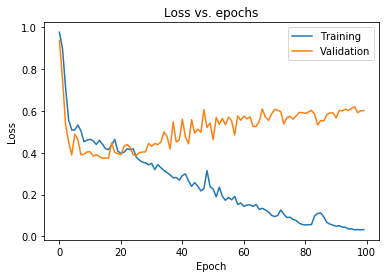

In [19]:
# Plot the training and validation loss

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

***
<a id="coding_tutorial_2"></a>
## Model regularisation

#### Adding regularisation with weight decay and dropout

In [20]:
from tensorflow.keras.layers import Dropout
from tensorflow.keras import regularizers

In [21]:
def get_regularised_model(wd, rate):
    model = Sequential([
        Dense(128,kernel_regularizer=regularizers.l2(wd),activation="relu", input_shape=(train_data.shape[1],)),
        Dropout(rate),
        Dense(128,kernel_regularizer=regularizers.l2(wd),activation="relu"),
        Dropout(rate),
        Dense(128, kernel_regularizer=regularizers.l2(wd),activation="relu"),
        Dropout(rate),
        Dense(128,kernel_regularizer=regularizers.l2(wd), activation="relu"),
        Dropout(rate),
        Dense(128, kernel_regularizer=regularizers.l2(wd),activation="relu"),
        Dropout(rate),
        Dense(128,kernel_regularizer=regularizers.l2(wd), activation="relu"),
        Dropout(rate),
        Dense(1)
    ])
    return model

In [22]:
# Re-build the model with weight decay and dropout layers
model=get_regularised_model(1e-5,0.3)


In [23]:
# Compile the model
model.compile(optimizer="adam",loss="mse",metrics=["mae"])


In [24]:
# Train the model, with some of the data reserved for validation
history=model.fit(train_data,train_target,epochs=100,batch_size=64,validation_split=0.15,verbose=False)


In [25]:
# Evaluate the model on the test set

model.evaluate(test_data,test_target,verbose=2)

45/1 - 0s - loss: 0.5589 - mae: 0.6402


[0.6758003625604841, 0.6402286]

#### Plot the learning curves

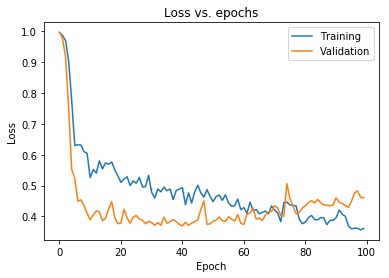

In [26]:
# Plot the training and validation loss

import matplotlib.pyplot as plt

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

***
<a id="coding_tutorial_3"></a>
## Introduction to callbacks

#### Example training callback

In [27]:
# Write a custom callback
from tensorflow.keras.callbacks import Callback
class Trainingcallback(Callback):
    def on_train_begin(self,logs=None):
        print("starting training...")
    def on_epoch_begin(self,epoch,logs=None):
        print(f"starting epoch {epoch}")
    def on_train_batch_begin(self,batch,logs=None):
        print(f"starting batch {batch}")
    def on_train_batch_end(self,batch,logs=None):
        print(f"finished batch{batch}")
    def on_epoch_end(self,epoch,logs=None):
        print(f"finished epoch{epoch}")
    def on_train_end(self,logs=None):
        print(f"finished training")
        
              
    

In [35]:
from tensorflow.keras.callbacks import Callback
class Testingcallback(Callback):
    def on_test_begin(self,logs=None):
        print("starting testing")
    def on_test_batch_begin(self,batch,logs=None):
        print(f"starting batch{batch}")
    def on_test_batch_end(self,batch,logs=None):
        print(f"finished batch{batch}")
    def on_test_end(self,logs=None):
        print("finished testing")

In [36]:
from tensorflow.keras.callbacks import Callback
class Predictioncallback(Callback):
    def on_predict_begin(self,logs=None):
        print("starting prediction")
    def on_predict_batch_begin(self,batch,logs=None):
        print(f"starting batch{batch}")
    def on_predict_batch_end(self,batch,logs=None):
        print(f"finished batch{batch}")
    def on_predict_end(self,logs=None):
        print("finished prediction")

In [28]:
# Re-build the model
model=get_regularised_model(1e-5,0.3)


In [29]:
# Compile the model
model.compile(optimizer="adam",loss="mse")


#### Train the model with the callback

In [31]:
# Train the model, with some of the data reserved for validation
model.fit(train_data,train_target,epochs=3,batch_size=128,verbose=False,callbacks=[Trainingcallback()])


starting training...
starting epoch 0
starting batch 0
finished batch0
starting batch 1
finished batch1
starting batch 2
finished batch2
starting batch 3
finished batch3
finished epoch0
starting epoch 1
starting batch 0
finished batch0
starting batch 1
finished batch1
starting batch 2
finished batch2
starting batch 3
finished batch3
finished epoch1
starting epoch 2
starting batch 0
finished batch0
starting batch 1
finished batch1
starting batch 2
finished batch2
starting batch 3
finished batch3
finished epoch2
finished training


In [37]:
# Evaluate the model
model.evaluate(test_data,test_target,verbose=2,callbacks=[Testingcallback()])


starting testing
starting batch0
finished batch0
starting batch1
finished batch1
45/1 - 0s - loss: 1.0580
finished testing


1.0325175417794121

In [38]:
# Make predictions with the model
model.predict(test_data,verbose=False,callbacks=[Predictioncallback()])


starting prediction
starting batch0
finished batch0
starting batch1
finished batch1
finished prediction


array([[ 0.0382524 ],
       [-0.05267857],
       [-0.11336039],
       [-0.09495707],
       [-0.10389416],
       [-0.03500545],
       [-0.06030104],
       [ 0.04055819],
       [ 0.05363364],
       [-0.00560306],
       [-0.08235115],
       [-0.03726944],
       [ 0.02268606],
       [ 0.05565598],
       [ 0.01289004],
       [ 0.01199127],
       [-0.07328989],
       [-0.00944016],
       [ 0.02592667],
       [-0.07987311],
       [-0.08161835],
       [-0.07261542],
       [ 0.05337453],
       [-0.09111068],
       [ 0.03302465],
       [ 0.02570564],
       [ 0.09266666],
       [ 0.03489817],
       [ 0.0501035 ],
       [ 0.0782949 ],
       [-0.10191394],
       [ 0.01663374],
       [ 0.04440466],
       [-0.05397856],
       [-0.07712857],
       [ 0.03517727],
       [-0.03854898],
       [-0.01605522],
       [ 0.06495262],
       [ 0.04223701],
       [ 0.00020147],
       [ 0.05615639],
       [-0.06099531],
       [-0.07074132],
       [ 0.05159349]], dtype=flo

***
<a id="coding_tutorial_4"></a>
## Early stopping / patience

#### Re-train the models with early stopping

In [52]:
# Re-train the unregularised model
unregularized_model=get_model()
unregularized_model.compile(optimizer="adam",loss="mse")
unreg_history=unregularized_model.fit(train_data,train_target,epochs=100,batch_size=64,validation_split=0.15,verbose=False,
                                      callbacks=[tf.keras.callbacks.EarlyStopping(patience=2)])


In [53]:
# Evaluate the model on the test set
unregularized_model.evaluate(test_data,test_target,verbose=2)


45/1 - 0s - loss: 0.6100


0.5809510323736403

In [54]:
# Re-train the regularised model
regularized_model=get_regularised_model(1e-8,0.2)
regularized_model.compile(optimizer="adam",loss="mse")
reg_history=regularized_model.fit(train_data,train_target,epochs=100,batch_size=64,validation_split=0.15,verbose=False,
                                  callbacks=[tf.keras.callbacks.EarlyStopping(patience=2)])


In [55]:
# Evaluate the model on the test set
regularized_model.evaluate(test_data,test_target,verbose=2)


45/1 - 0s - loss: 0.5750


0.6269655956162347

#### Plot the learning curves

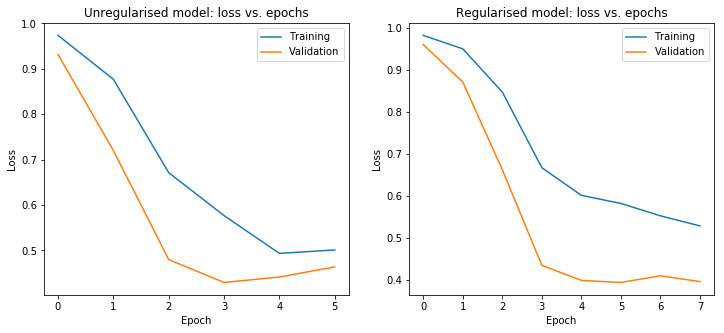

In [56]:
# Plot the training and validation loss

import matplotlib.pyplot as plt

fig = plt.figure(figsize=(12, 5))

fig.add_subplot(121)

plt.plot(unreg_history.history['loss'])
plt.plot(unreg_history.history['val_loss'])
plt.title('Unregularised model: loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')

fig.add_subplot(122)

plt.plot(reg_history.history['loss'])
plt.plot(reg_history.history['val_loss'])
plt.title('Regularised model: loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')

plt.show()